In [395]:
import numpy as np
import math
from matplotlib import pyplot as plt
import gym
from random import random
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 4)

In [393]:
def plot_histogram(x, title=None):
    hist, bins = x
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    if title is not None:
        plt.title(title)
    plt.show()
    
def heatmap(a, cmap='gray'):
    """a: 2D array to plot as a heatmap"""
    plt.imshow(a, cmap=cmap, interpolation='nearest')
    plt.show()
    
tr = np.transpose

In [83]:
gamma = 0.9
dt = 1.0 /  50.0

In [25]:
env = gym.make("CartPole-v0")

[2016-10-18 12:23:10,514] Making new env: CartPole-v0


Actions $\mathcal A: \{\text{left}, \text{right}\}$

# Fully Random Policy

In [36]:
trajectories = []

# observation: x, x_dot, theta, theta_dot
observation = env.reset()
for i_episode in range(20):
    observation = env.reset()
    traj = []
    for t in range(100):
        env.render()
        #print(observation)
        action = env.action_space.sample()
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        if done:
            reward = -50
        traj.append((action, prev_observation, reward, done))
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    trajectories.append(traj)

Episode finished after 12 timesteps
Episode finished after 12 timesteps
Episode finished after 43 timesteps
Episode finished after 16 timesteps
Episode finished after 34 timesteps
Episode finished after 54 timesteps
Episode finished after 18 timesteps
Episode finished after 39 timesteps
Episode finished after 18 timesteps
Episode finished after 21 timesteps
Episode finished after 17 timesteps
Episode finished after 21 timesteps
Episode finished after 15 timesteps
Episode finished after 71 timesteps
Episode finished after 28 timesteps
Episode finished after 11 timesteps
Episode finished after 20 timesteps
Episode finished after 13 timesteps
Episode finished after 12 timesteps
Episode finished after 71 timesteps


In [60]:
# Average duration
sum([len(traj) for traj in trajectories]) / len(trajectories)

27.3

In [61]:
Action, Obs, Reward, Done = 0, 1, 2, 3
for traj in trajectories:
    x_0 = traj[0][Obs]
    R = 0
    for x in traj[::-1]:
        R = x[Reward] + R * gamma
    print(x_0, R, len(traj))

[ 0.01370144 -0.01205928 -0.03470469 -0.0408302 ] -8.828635765400003 12
[ 0.02874139  0.04588371 -0.00927307 -0.00070243] -8.828635765400003 12
[ 0.04386674 -0.00966353  0.01890295  0.01365569] 9.281649089046281 43
[-0.0050513  -0.03123911 -0.01662002  0.03481083] -2.353467925678943 16
[-0.04709323  0.03186341  0.00947133  0.02545898] 8.145810737042044 34
[-0.0210569   0.04903357  0.02435963  0.04152144] 9.774573872431821 54
[ 0.04993272 -0.01103582 -0.00818521  0.01847771] -0.006309019799944027 18
[ 0.04702919 -0.02640325 -0.03315298 -0.03255436] 8.905119782115959 39
[ 0.00034997 -0.00106669  0.00706787 -0.04142051] -0.006309019799944027 18
[ 0.03458408  0.00352018 -0.00168446  0.01088663] 2.7054007245658407 21
[ 0.01013099  0.04519625 -0.03091479  0.00633722] -1.1181211331110488 17
[-0.03977525 -0.02258343 -0.0128508  -0.04961488] 2.7054007245658407 21
[-0.03411014  0.01555932  0.02454369 -0.03473274] -3.7260754729766035 15
[-0.00872943  0.03395447 -0.04975529 -0.02543827] 9.96240527

The previous block is used to determine a reasonable value of gamma. We check that there is enough diversity in the values and that the reward $R$ matches the length of the trajectory.

In [50]:
obs = []
for i in range(4):
    obs.append(np.array([x[Obs][i] for x in traj for traj in trajectories]))
    print(obs[i].min(), obs[i].max())

-0.135942954037 0.48135709627
-0.604424629412 1.50939634907
-0.206149872033 0.128826537503
-1.55798899635 0.952707698624


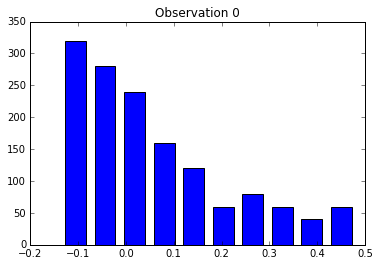

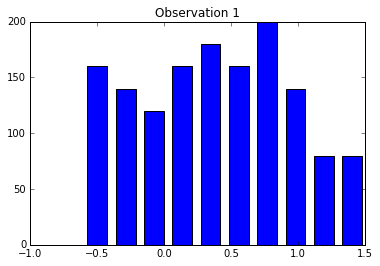

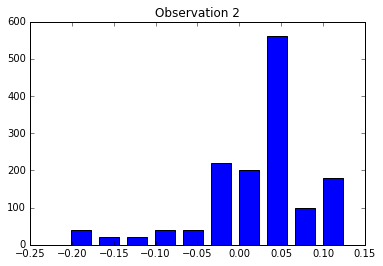

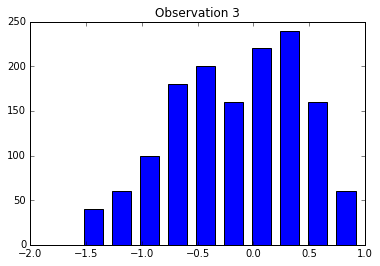

In [59]:
for i in range(4):
    plot_histogram(np.histogram(obs[i]), title="Observation " + str(i))

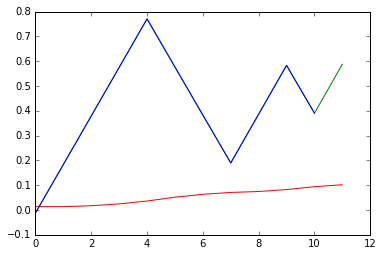

In [85]:
# We check that Obs[1] is indeed the derivative of x = Obs[0]
traj = trajectories[0]
x = [p[Obs][0] for p in traj]
x_dot = [p[Obs][1] for p in traj]
plt.plot(range(len(traj)), x, color='red')
plt.plot(range(len(traj)), x_dot, color='green')

test = np.array(x)
plt.plot(range(len(traj) - 1), (test[1:] - test[:-1]) / dt, color='blue')

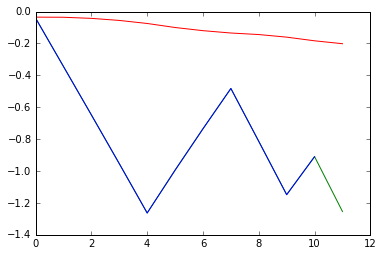

In [87]:
# same for theta
traj = trajectories[0]
theta = [p[Obs][2] for p in traj]
theta_dot = [p[Obs][3] for p in traj]
plt.plot(range(len(traj)), theta, color='red')
plt.plot(range(len(traj)), theta_dot, color='green')

test = np.array(theta)
plt.plot(range(len(traj) - 1), (test[1:] - test[:-1]) / dt, color='blue')

# Temporal Difference — First Test
## Premilinary step: State space discretization

In [461]:
nb_theta_states = 32
def theta_state(theta):
    """Returns the discrete state associated to the angle theta"""
    # -15°, 15° -> 0, 31 (step of 1°)
    return max(0, min(nb_theta_states - 1, math.ceil(theta * 180 / math.pi) + 15))

nb_x_states = 50
def x_state(x):
    """Returns the discrete state associated to the position x"""
    # -2.4, 2.4° -> 0, 49 (step of 0.1)
    return max(0, min(49, math.ceil(x * 10) + 24))

nb_theta_dot_states = 42
def theta_dot_state(theta_dot):
    """Returns the discrete state associated to the angle velocity theta dot"""
    # -2, 2° -> 0, 41 (step of 0.1)
    return max(0, min(nb_theta_dot_states - 1, math.ceil(theta_dot * 10) + 20))

nb_x_dot_states = 42
def theta_dot_state(x_dot):
    """Returns the discrete state associated to the linear velocity theta dot"""
    # -2, 2° -> 0, 41 (step of 0.1)
    return max(0, min(nb_x_dot_states - 1, math.ceil(x_dot * 10) + 20))

# Note: It might well be more efficient to use non-regular grid

## Theta only

We first look exclusively at theta, then add other state dimensions

In [418]:
Q = np.zeros((nb_theta_states, env.action_space.n))
#Q[:16,0] = 1
#Q[:16,1] = 0
#Q[16:,0] = 0
#Q[16:,1] = 1

In [419]:
prior_trajectories = trajectories

def policy(observation):
    theta = observation[2]
    s = theta_state(theta)
    
    #if Q[s, 0] == Q[s, 1]:
    #    return env.action_space.sample()
    #return np.argmax(Q[s])
    p = np.exp(Q[s])
    if random() < p[0] / p.sum():
        return 0
    else:
        return 1

alpha_0 = 0.5
alpha_decay = 0.0
gamma = 0.95
def make_alpha(t, s, a):
    return alpha_0 / (t + 1) ** alpha_decay

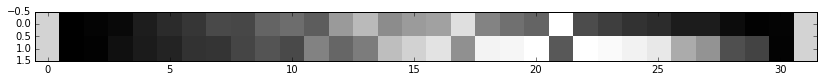

[2016-10-19 18:48:07,502] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:48:07,834] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 18 timesteps


[2016-10-19 18:48:08,118] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 19 timesteps


[2016-10-19 18:48:08,703] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:48:09,024] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 20 timesteps


[2016-10-19 18:48:09,390] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:48:10,181] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:48:10,493] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 16 timesteps


[2016-10-19 18:48:10,796] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 17 timesteps


[2016-10-19 18:48:11,551] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 44 timesteps


[2016-10-19 18:48:12,335] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:48:12,552] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps
Episode finished after 13 timesteps


[2016-10-19 18:48:12,791] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 16 timesteps


[2016-10-19 18:48:13,204] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:48:13,489] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 16 timesteps


[2016-10-19 18:48:13,790] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 19 timesteps


[2016-10-19 18:48:14,141] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:48:14,442] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 18 timesteps


[2016-10-19 18:48:14,977] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:48:15,713] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:48:16,249] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:48:16,513] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 18 timesteps


[2016-10-19 18:48:16,896] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:48:17,402] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:48:17,686] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 17 timesteps


[2016-10-19 18:48:18,121] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:48:18,420] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 18 timesteps


[2016-10-19 18:48:18,704] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps


[2016-10-19 18:48:18,939] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps


[2016-10-19 18:48:19,205] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 16 timesteps


[2016-10-19 18:48:19,624] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 24 timesteps


[2016-10-19 18:48:20,098] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:48:20,710] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:48:20,963] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps


[2016-10-19 18:48:21,329] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:48:21,532] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 20 timesteps
Episode finished after 11 timesteps


[2016-10-19 18:48:21,851] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:48:22,036] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 19 timesteps
Episode finished after 11 timesteps


[2016-10-19 18:48:22,387] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:48:22,905] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:48:23,252] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:48:24,409] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


[2016-10-19 18:48:25,144] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 44 timesteps


[2016-10-19 18:48:25,948] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 48 timesteps


[2016-10-19 18:48:27,334] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 82 timesteps


[2016-10-19 18:48:27,941] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 50 timesteps


[2016-10-19 18:48:28,857] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:48:29,576] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 95 timesteps


[2016-10-19 18:48:31,100] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:48:31,988] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


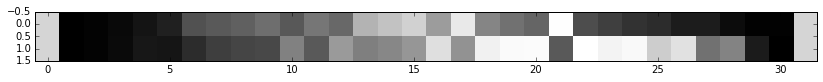

[2016-10-19 18:48:34,643] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:48:35,228] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:48:35,980] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:48:36,349] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:48:37,000] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:48:37,554] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:48:38,220] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 39 timesteps


[2016-10-19 18:48:38,778] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:48:41,014] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:48:41,969] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 56 timesteps


[2016-10-19 18:48:42,603] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:48:43,923] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 77 timesteps


[2016-10-19 18:48:45,263] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 79 timesteps


[2016-10-19 18:48:45,931] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:48:46,536] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:48:47,818] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 77 timesteps


[2016-10-19 18:48:48,721] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


[2016-10-19 18:48:49,260] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:48:49,993] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 81 timesteps


[2016-10-19 18:48:51,179] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:48:51,801] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:48:52,384] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:48:53,239] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 49 timesteps


[2016-10-19 18:48:53,858] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:48:54,440] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:48:57,269] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 67 timesteps


[2016-10-19 18:48:58,005] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 46 timesteps


[2016-10-19 18:48:58,641] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:48:59,309] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:49:01,482] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:02,019] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:02,721] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 44 timesteps


[2016-10-19 18:49:03,523] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 48 timesteps


[2016-10-19 18:49:04,845] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 77 timesteps


[2016-10-19 18:49:05,196] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:49:05,748] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:07,152] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 85 timesteps


[2016-10-19 18:49:07,687] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:49:08,239] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 50 timesteps


[2016-10-19 18:49:09,058] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:10,079] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 61 timesteps


[2016-10-19 18:49:10,647] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:49:11,283] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:49:11,885] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:49:12,855] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 57 timesteps


[2016-10-19 18:49:13,474] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:49:14,443] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 59 timesteps


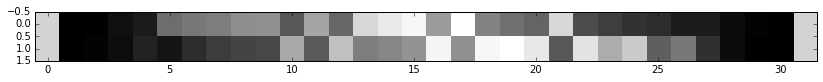

[2016-10-19 18:49:15,881] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:49:16,768] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 91 timesteps


[2016-10-19 18:49:17,838] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:49:18,290] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:49:18,808] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:49:19,577] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:49:20,798] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:49:21,634] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:49:22,621] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 60 timesteps


[2016-10-19 18:49:23,925] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:49:25,313] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 60 timesteps


[2016-10-19 18:49:26,199] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 53 timesteps


[2016-10-19 18:49:26,735] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:49:27,320] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 71 timesteps


[2016-10-19 18:49:28,591] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 39 timesteps


[2016-10-19 18:49:29,109] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:49:29,561] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:49:31,751] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:49:32,404] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:49:33,039] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 57 timesteps


[2016-10-19 18:49:33,908] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 56 timesteps


[2016-10-19 18:49:34,644] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 24 timesteps


[2016-10-19 18:49:35,330] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 39 timesteps


[2016-10-19 18:49:37,371] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:49:37,923] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:38,758] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 50 timesteps


[2016-10-19 18:49:39,999] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 74 timesteps


[2016-10-19 18:49:40,395] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:49:41,466] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 62 timesteps


[2016-10-19 18:49:42,101] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:49:42,618] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:43,254] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:49:44,008] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:49:44,917] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


[2016-10-19 18:49:46,183] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 75 timesteps


[2016-10-19 18:49:46,767] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:49:48,041] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 75 timesteps


[2016-10-19 18:49:48,777] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 44 timesteps


[2016-10-19 18:49:49,393] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:49:50,666] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 77 timesteps


[2016-10-19 18:49:51,637] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 58 timesteps


[2016-10-19 18:49:52,035] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:49:52,725] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:49:53,423] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 61 timesteps


[2016-10-19 18:49:54,309] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:54,865] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:49:55,817] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 56 timesteps


[2016-10-19 18:49:56,488] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


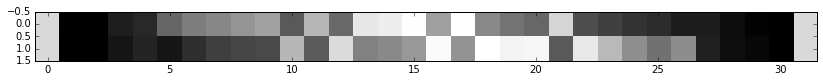

[2016-10-19 18:49:58,208] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:49:58,709] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:49:59,296] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:49:59,896] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:50:01,400] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 86 timesteps


[2016-10-19 18:50:01,951] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:50:02,891] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 55 timesteps


[2016-10-19 18:50:03,506] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:50:04,112] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:50:04,711] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:50:05,307] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:50:05,865] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:06,700] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:50:07,185] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:50:07,624] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:50:08,072] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:50:08,377] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 16 timesteps


[2016-10-19 18:50:08,675] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 17 timesteps


[2016-10-19 18:50:09,074] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 24 timesteps


[2016-10-19 18:50:09,511] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:50:09,750] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 13 timesteps


[2016-10-19 18:50:10,031] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 17 timesteps


[2016-10-19 18:50:10,580] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:11,149] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:50:11,751] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:50:12,087] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 20 timesteps


[2016-10-19 18:50:12,787] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:50:13,828] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 65 timesteps


[2016-10-19 18:50:14,511] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 39 timesteps


[2016-10-19 18:50:15,064] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:50:15,482] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 24 timesteps


[2016-10-19 18:50:16,199] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 42 timesteps


[2016-10-19 18:50:16,586] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:50:17,227] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:50:17,637] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:50:18,157] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:18,778] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:50:19,212] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:50:20,099] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


[2016-10-19 18:50:20,467] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:50:20,966] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:50:21,506] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:50:22,191] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:50:22,492] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 18 timesteps


[2016-10-19 18:50:22,890] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:50:23,527] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:50:24,126] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:50:24,529] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:50:25,317] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 60 timesteps


[2016-10-19 18:50:25,818] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps


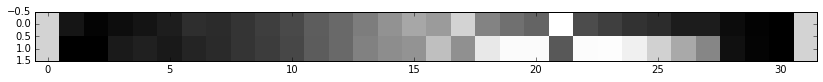

[2016-10-19 18:50:27,555] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:50:27,906] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:50:28,209] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 18 timesteps


[2016-10-19 18:50:28,875] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:50:29,794] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 51 timesteps


[2016-10-19 18:50:30,195] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:50:30,799] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:50:31,168] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:50:31,350] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 19 timesteps
Episode finished after 11 timesteps


[2016-10-19 18:50:31,855] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:50:32,153] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 13 timesteps


[2016-10-19 18:50:32,649] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:50:32,990] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:50:33,181] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps
Episode finished after 10 timesteps


[2016-10-19 18:50:33,527] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 20 timesteps


[2016-10-19 18:50:33,791] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps


[2016-10-19 18:50:34,264] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:50:34,778] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:50:34,963] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps
Episode finished after 10 timesteps


[2016-10-19 18:50:35,448] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:50:35,835] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:50:37,090] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 73 timesteps


[2016-10-19 18:50:37,594] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:50:38,106] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:50:38,526] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:50:38,963] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:50:39,345] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:50:39,800] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:50:40,181] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:50:40,749] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:50:41,371] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:50:41,874] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:50:42,406] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:50:42,638] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps


[2016-10-19 18:50:43,309] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:50:43,858] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:44,262] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:50:44,761] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:45,232] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:50:45,482] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 13 timesteps


[2016-10-19 18:50:46,001] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:50:46,256] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:50:46,467] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 14 timesteps
Episode finished after 18 timesteps


[2016-10-19 18:50:47,069] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:47,873] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 45 timesteps


[2016-10-19 18:50:48,393] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:48,894] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:50:49,175] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 16 timesteps


[2016-10-19 18:50:49,796] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:50:50,619] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


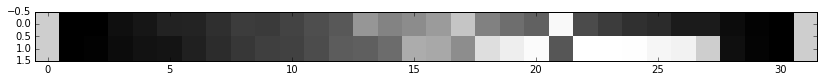

[2016-10-19 18:50:52,206] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:50:52,656] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 20 timesteps


[2016-10-19 18:50:53,564] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 67 timesteps


[2016-10-19 18:50:54,414] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:50:55,013] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:50:55,252] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 14 timesteps


[2016-10-19 18:50:55,632] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:50:55,999] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:50:56,552] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:50:57,289] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 43 timesteps


[2016-10-19 18:50:57,833] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:50:58,223] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:50:58,591] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:50:58,976] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:50:59,194] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps
Episode finished after 12 timesteps


[2016-10-19 18:50:59,629] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:50:59,887] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 13 timesteps


[2016-10-19 18:51:00,147] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 15 timesteps


[2016-10-19 18:51:00,381] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 13 timesteps


[2016-10-19 18:51:00,733] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:51:01,385] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:51:01,623] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 13 timesteps


[2016-10-19 18:51:02,174] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:51:02,826] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:51:03,412] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:51:03,911] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:51:04,343] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 24 timesteps


[2016-10-19 18:51:05,094] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 44 timesteps


[2016-10-19 18:51:05,633] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 60 timesteps


[2016-10-19 18:51:06,573] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:51:07,155] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:51:07,605] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:51:08,141] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:51:08,846] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 43 timesteps


[2016-10-19 18:51:09,427] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:51:10,298] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 52 timesteps


[2016-10-19 18:51:10,802] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:51:11,351] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:51:12,123] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 45 timesteps


[2016-10-19 18:51:12,606] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:51:13,123] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:51:13,511] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 24 timesteps


[2016-10-19 18:51:13,947] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:51:14,614] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 39 timesteps


[2016-10-19 18:51:15,115] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:51:16,338] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 71 timesteps


[2016-10-19 18:51:17,206] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 51 timesteps


[2016-10-19 18:51:17,925] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 45 timesteps


[2016-10-19 18:51:18,458] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:51:18,794] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 20 timesteps


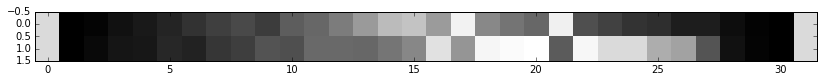

[2016-10-19 18:51:20,286] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:51:20,768] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:51:21,302] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:51:21,691] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:51:22,393] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:51:23,093] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 42 timesteps


[2016-10-19 18:51:23,728] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:51:25,116] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 83 timesteps


[2016-10-19 18:51:25,867] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 46 timesteps


[2016-10-19 18:51:26,492] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:51:26,856] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:51:27,456] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:51:28,042] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 50 timesteps


[2016-10-19 18:51:28,977] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:51:29,516] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:51:30,017] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:51:31,188] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 71 timesteps


[2016-10-19 18:51:31,723] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:51:32,439] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 65 timesteps


[2016-10-19 18:51:33,444] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:51:34,331] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


[2016-10-19 18:51:35,080] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 45 timesteps


[2016-10-19 18:51:35,700] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:51:36,870] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 67 timesteps


[2016-10-19 18:51:37,508] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:51:38,390] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:51:38,947] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 57 timesteps


[2016-10-19 18:51:39,748] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:51:41,019] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 73 timesteps


[2016-10-19 18:51:41,401] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:51:41,938] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:51:42,724] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 45 timesteps


[2016-10-19 18:51:43,510] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 49 timesteps


[2016-10-19 18:51:43,980] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:51:44,749] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 68 timesteps


[2016-10-19 18:51:45,616] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:51:46,268] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:51:46,856] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:51:47,742] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 64 timesteps


[2016-10-19 18:51:49,280] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 74 timesteps


[2016-10-19 18:51:49,777] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:51:50,350] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:51:51,636] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 78 timesteps


[2016-10-19 18:51:52,506] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:51:52,907] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:51:54,083] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 69 timesteps


[2016-10-19 18:51:54,629] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:51:55,148] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:51:55,971] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 46 timesteps


[2016-10-19 18:51:56,973] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


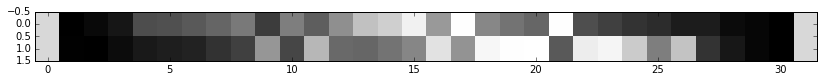

[2016-10-19 18:51:58,795] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 42 timesteps


[2016-10-19 18:52:00,066] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 71 timesteps


[2016-10-19 18:52:00,649] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:52:01,373] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:52:01,803] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:52:02,354] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:52:02,925] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:52:03,594] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 32 timesteps


[2016-10-19 18:52:04,114] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 52 timesteps


[2016-10-19 18:52:05,068] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:52:05,616] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:52:06,353] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 63 timesteps


[2016-10-19 18:52:07,355] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:52:07,961] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:52:08,794] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:52:09,297] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:52:10,151] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 48 timesteps


[2016-10-19 18:52:10,573] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:52:11,137] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:52:12,257] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 93 timesteps


[2016-10-19 18:52:13,319] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:52:13,927] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:52:14,564] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:52:14,986] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:52:15,585] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:52:16,086] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:52:16,470] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:52:17,555] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 58 timesteps


[2016-10-19 18:52:18,146] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:52:19,178] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 62 timesteps


[2016-10-19 18:52:19,952] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:52:20,386] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:52:21,136] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 44 timesteps


[2016-10-19 18:52:21,572] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:52:22,092] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:52:23,309] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 72 timesteps


[2016-10-19 18:52:23,979] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:52:24,939] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 55 timesteps


[2016-10-19 18:52:26,539] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 97 timesteps


[2016-10-19 18:52:27,340] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 45 timesteps


[2016-10-19 18:52:28,218] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 49 timesteps


[2016-10-19 18:52:28,727] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:52:29,652] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 55 timesteps


[2016-10-19 18:52:30,101] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:52:30,719] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:52:31,373] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:52:31,990] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 34 timesteps


[2016-10-19 18:52:32,674] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 39 timesteps


[2016-10-19 18:52:33,478] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:52:34,501] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 59 timesteps


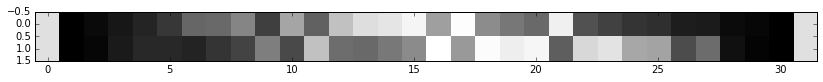

[2016-10-19 18:52:36,558] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


[2016-10-19 18:52:37,626] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 63 timesteps


[2016-10-19 18:52:38,596] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 58 timesteps


[2016-10-19 18:52:39,164] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:52:39,399] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps
Episode finished after 14 timesteps


[2016-10-19 18:52:40,552] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 69 timesteps


[2016-10-19 18:52:41,359] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 46 timesteps


[2016-10-19 18:52:42,423] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 62 timesteps


[2016-10-19 18:52:43,228] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:52:43,863] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:52:44,580] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 43 timesteps


[2016-10-19 18:52:45,350] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 43 timesteps


[2016-10-19 18:52:46,120] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-19 18:52:47,727] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 44 timesteps


[2016-10-19 18:52:48,142] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 42 timesteps


[2016-10-19 18:52:49,280] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 48 timesteps


[2016-10-19 18:52:49,952] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:52:50,317] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:52:51,189] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 52 timesteps


[2016-10-19 18:52:52,239] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 61 timesteps


[2016-10-19 18:52:53,244] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 58 timesteps


[2016-10-19 18:52:54,550] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 78 timesteps


[2016-10-19 18:52:55,287] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:52:56,207] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 56 timesteps


[2016-10-19 18:52:58,566] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:52:59,568] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 59 timesteps


[2016-10-19 18:53:00,351] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 66 timesteps


[2016-10-19 18:53:01,489] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 87 timesteps


[2016-10-19 18:53:02,796] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:53:03,410] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:53:04,232] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 48 timesteps


[2016-10-19 18:53:04,750] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:53:05,887] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 67 timesteps


[2016-10-19 18:53:06,277] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:53:06,888] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 36 timesteps


[2016-10-19 18:53:07,729] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 51 timesteps


[2016-10-19 18:53:08,361] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 78 timesteps


[2016-10-19 18:53:09,634] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 33 timesteps


[2016-10-19 18:53:10,268] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:53:10,852] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:53:11,989] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 66 timesteps


[2016-10-19 18:53:12,407] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:53:13,463] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 60 timesteps


[2016-10-19 18:53:13,933] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:53:14,410] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 28 timesteps


[2016-10-19 18:53:15,133] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 43 timesteps


[2016-10-19 18:53:16,005] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 51 timesteps


[2016-10-19 18:53:16,640] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 40 timesteps


[2016-10-19 18:53:17,426] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 45 timesteps


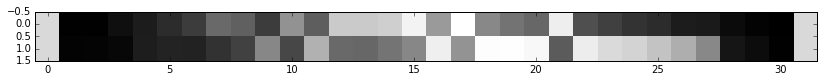

[2016-10-19 18:53:19,533] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 53 timesteps


[2016-10-19 18:53:21,171] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 96 timesteps


[2016-10-19 18:53:21,856] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:53:22,744] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 54 timesteps


[2016-10-19 18:53:23,412] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 38 timesteps


[2016-10-19 18:53:24,086] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 42 timesteps


[2016-10-19 18:53:24,832] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 62 timesteps


[2016-10-19 18:53:25,573] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 25 timesteps


[2016-10-19 18:53:26,323] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 72 timesteps


[2016-10-19 18:53:27,375] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 58 timesteps


[2016-10-19 18:53:28,979] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 73 timesteps


[2016-10-19 18:53:29,951] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 55 timesteps


[2016-10-19 18:53:30,404] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:53:30,892] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 29 timesteps


[2016-10-19 18:53:31,453] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 50 timesteps


[2016-10-19 18:53:32,709] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 59 timesteps


[2016-10-19 18:53:33,197] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:53:34,013] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 49 timesteps


[2016-10-19 18:53:34,605] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 35 timesteps


[2016-10-19 18:53:35,404] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:53:36,055] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 53 timesteps


[2016-10-19 18:53:36,962] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 39 timesteps


[2016-10-19 18:53:37,659] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 43 timesteps


[2016-10-19 18:53:38,093] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:53:38,881] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 48 timesteps


[2016-10-19 18:53:39,849] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 56 timesteps


[2016-10-19 18:53:40,287] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 27 timesteps


[2016-10-19 18:53:40,871] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 37 timesteps


[2016-10-19 18:53:41,237] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 21 timesteps


[2016-10-19 18:53:42,477] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 71 timesteps


[2016-10-19 18:53:42,913] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 26 timesteps


[2016-10-19 18:53:43,296] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 41 timesteps


[2016-10-19 18:53:43,963] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 22 timesteps


[2016-10-19 18:53:44,718] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 60 timesteps


[2016-10-19 18:53:45,873] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 53 timesteps


[2016-10-19 18:53:46,740] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 71 timesteps


[2016-10-19 18:53:48,545] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 87 timesteps


[2016-10-19 18:53:49,083] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:53:49,987] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 53 timesteps


[2016-10-19 18:53:50,803] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 49 timesteps


[2016-10-19 18:53:51,307] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 30 timesteps


[2016-10-19 18:53:51,605] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 19 timesteps


[2016-10-19 18:53:52,493] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 50 timesteps


[2016-10-19 18:53:53,281] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 47 timesteps


[2016-10-19 18:53:53,830] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 31 timesteps


[2016-10-19 18:53:54,770] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 56 timesteps


[2016-10-19 18:53:55,758] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 96 timesteps


[2016-10-19 18:53:57,343] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 58 timesteps


[2016-10-19 18:53:57,742] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 23 timesteps


[2016-10-19 18:53:58,364] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Episode finished after 52 timesteps


In [429]:
trajectories = []
log_actions = []

observation = env.reset()
for i_episode in range(500):
    if i_episode % 50 == 0:
        heatmap(tr(Q))
    observation = env.reset()
    traj = []
    for t in range(100):
        env.render()
        action = policy(observation)
        log_actions.append(action)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        done = abs(observation[2] * 180 / math.pi) > 15
        if done:
            reward = -50
        
        # update Q
        prev_theta = prev_observation[2]
        prev_s = theta_state(prev_theta)
        theta = observation[2]
        s = theta_state(theta)
        delta = reward + gamma * max(Q[s])
        alpha = make_alpha(t, prev_s, action)
        Q[prev_s, action] = (1 - alpha) * Q[prev_s, action] + alpha * delta
        
        traj.append((action, prev_observation, reward, done))
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        
        
    trajectories.append(traj)

In [431]:
# Average duration
sum([len(traj) for traj in trajectories]) / len(trajectories)

39.892

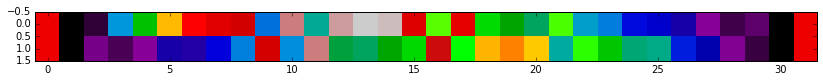

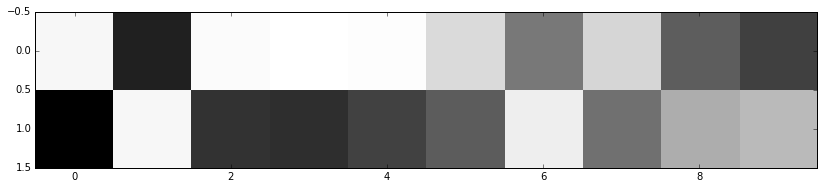

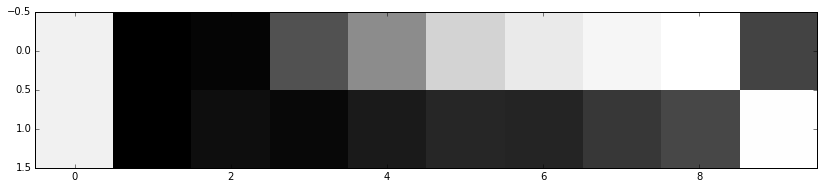

(None, None, None)

In [432]:
heatmap(tr(Q), cmap='spectral'), heatmap(tr(Q[10:20,:])), heatmap(tr(Q[:10,:]))

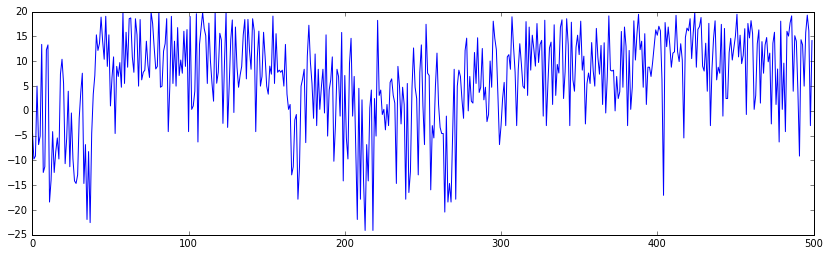

In [433]:
Action, Obs, Reward, Done = 0, 1, 2, 3
Rs = []
for traj in trajectories:
    x_0 = traj[0][Obs]
    R = 0
    for x in traj[::-1]:
        R = x[Reward] + R * gamma
    Rs.append(R)

plt.plot(range(len(Rs)), Rs)

In [428]:
oldQ = Q

## Theta and Theta dot

In [442]:
Q = np.zeros((nb_theta_states, nb_theta_dot_states, env.action_space.n))

In [443]:
def state(observation):
    theta = observation[2]
    theta_dot = observation[3]
    s1 = theta_state(theta)
    s2 = theta_dot_state(theta_dot)
    return s1, s2

def policy(observation):
    s1, s2 = state(observation)
    
    #if Q[s, 0] == Q[s, 1]:
    #    return env.action_space.sample()
    #return np.argmax(Q[s])
    p = np.exp(Q[s1, s2])
    if random() < p[0] / p.sum():
        return 0
    else:
        return 1

alpha_0 = 0.5
alpha_decay = 0.0
gamma = 0.95
def make_alpha(t, s, a):
    return alpha_0 / (t + 1) ** alpha_decay

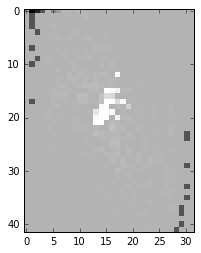

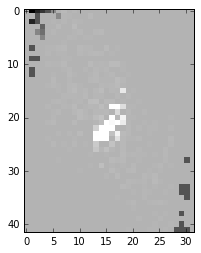

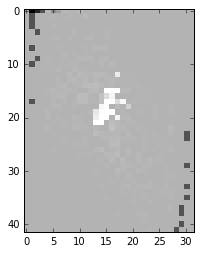

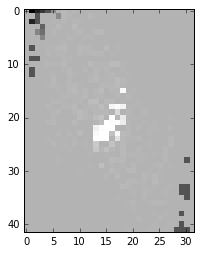

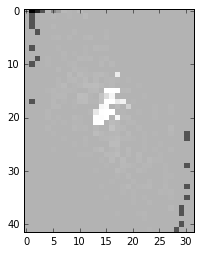

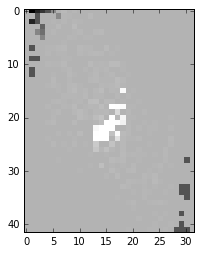

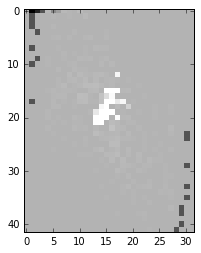

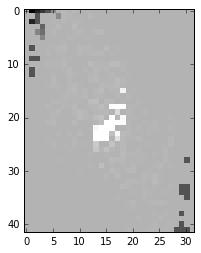

Episode finished after 11 timesteps
Episode finished after 11 timesteps


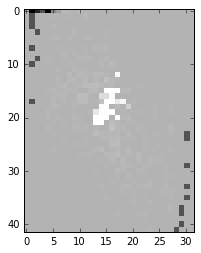

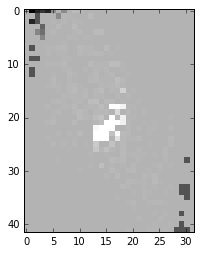

Episode finished after 11 timesteps


In [458]:
trajectories = []

observation = env.reset()
for i_episode in range(100):
    if i_episode % 20 == 0:
        heatmap(tr(Q[:,:,0]))
        heatmap(tr(Q[:,:,1]))
    observation = env.reset()
    traj = []
    for t in range(200):
        env.render()
        action = policy(observation)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        #done = abs(observation[2] * 180 / math.pi) > 15
        if done:
            reward = -50
        
        # update Q
        prev_s1, prev_s2 = state(prev_observation)
        s1, s2 = state(observation)
        delta = reward + gamma * max(Q[s1, s2])
        alpha = make_alpha(t, prev_s, action)
        Q[prev_s1, prev_s2, action] = (1 - alpha) * Q[prev_s1, prev_s2, action] + alpha * delta
        
        traj.append((action, prev_observation, reward, done))
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        
        
    trajectories.append(traj)

In [459]:
# Average duration
sum([len(traj) for traj in trajectories]) / len(trajectories)

194.33

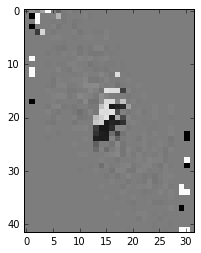

In [452]:
heatmap(tr(Q[:,:,0] - Q[:,:,1]))

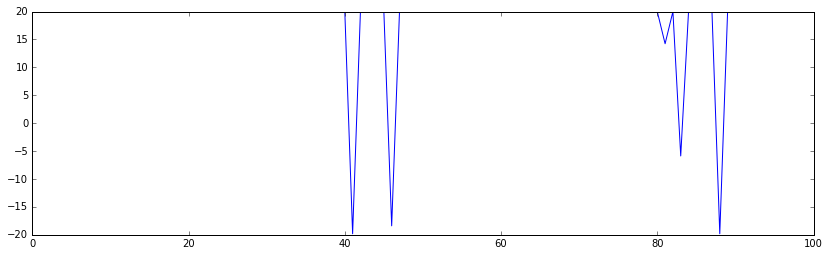

In [456]:
Action, Obs, Reward, Done = 0, 1, 2, 3
Rs = []
for traj in trajectories:
    x_0 = traj[0][Obs]
    R = 0
    for x in traj[::-1]:
        R = x[Reward] + R * gamma
    Rs.append(R)

plt.plot(range(len(Rs)), Rs)

In [457]:
Q_ok = Q

## All-in

In [470]:
nb_theta_states = 32
def theta_state(theta):
    """Returns the discrete state associated to the angle theta"""
    # -15°, 15° -> 0, 31 (step of 1°)
    return max(0, min(nb_theta_states - 1, math.ceil(theta * 180 / math.pi) + 15))

nb_x_states = 50
def x_state(x):
    """Returns the discrete state associated to the position x"""
    # -2.4, 2.4° -> 0, 49 (step of 0.1)
    return max(0, min(49, math.ceil(x * 10) + 24))

nb_theta_dot_states = 2
def theta_dot_state(theta_dot):
    """Returns the discrete state associated to the angle velocity theta dot"""
    # keep sign only
    if theta_dot < 0:
        return 0
    else:
        return 1

nb_x_dot_states = 2
def x_dot_state(x_dot):
    """Returns the discrete state associated to the linear velocity theta dot"""
    # keep sign only
    if x_dot < 0:
        return 0
    else:
        return 1

# Note: It might well be more efficient to use non-regular grid

In [471]:
Q = np.zeros((nb_x_states, nb_x_dot_states, nb_theta_states, nb_theta_dot_states, env.action_space.n))

In [472]:
def state(observation):
    x, x_dot, theta, theta_dot = observation
    sx = x_state(x)
    sxd = x_dot_state(x_dot)
    st = theta_state(theta)
    std = theta_dot_state(theta_dot)
    return sx, sxd, st, std

def policy(observation):
    sx, sxd, st, std = state(observation)
    
    p = np.exp(Q[sx, sxd, st, std])
    if random() < p[0] / p.sum():
        return 0
    else:
        return 1

alpha_0 = 0.5
alpha_decay = 0.0
gamma = 0.95
def make_alpha(t, s, a):
    return alpha_0 / (t + 1) ** alpha_decay

In [484]:
trajectories = []

observation = env.reset()
for i_episode in range(100):
    observation = env.reset()
    traj = []
    for t in range(200):
        env.render()
        action = policy(observation)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        if done:
            reward = -50
        
        # update Q
        prev_sx, prev_sxd, prev_st, prev_std = state(prev_observation)
        sx, sxd, st, std = state(observation)
        delta = reward + gamma * max(Q[sx, sxd, st, std])
        alpha = make_alpha(t, prev_s, action)
        Q[prev_sx, prev_sxd, prev_st, prev_std, action] = (1 - alpha) * Q[prev_sx, prev_sxd, prev_st, prev_std, action] + alpha * delta
        
        traj.append((action, prev_observation, reward, done))
        if done:
            break
        
    print("Episode finished after {} timesteps".format(t+1))
    trajectories.append(traj)

Episode finished after 126 timesteps
Episode finished after 55 timesteps
Episode finished after 39 timesteps
Episode finished after 49 timesteps
Episode finished after 51 timesteps
Episode finished after 25 timesteps
Episode finished after 62 timesteps
Episode finished after 129 timesteps
Episode finished after 33 timesteps
Episode finished after 158 timesteps
Episode finished after 133 timesteps
Episode finished after 109 timesteps
Episode finished after 200 timesteps
Episode finished after 85 timesteps
Episode finished after 166 timesteps
Episode finished after 41 timesteps
Episode finished after 59 timesteps
Episode finished after 85 timesteps
Episode finished after 47 timesteps
Episode finished after 106 timesteps
Episode finished after 163 timesteps
Episode finished after 54 timesteps
Episode finished after 105 timesteps
Episode finished after 101 timesteps
Episode finished after 131 timesteps
Episode finished after 37 timesteps
Episode finished after 60 timesteps
Episode finished

In [482]:
# Average duration
sum([len(traj) for traj in trajectories]) / len(trajectories)

77.95

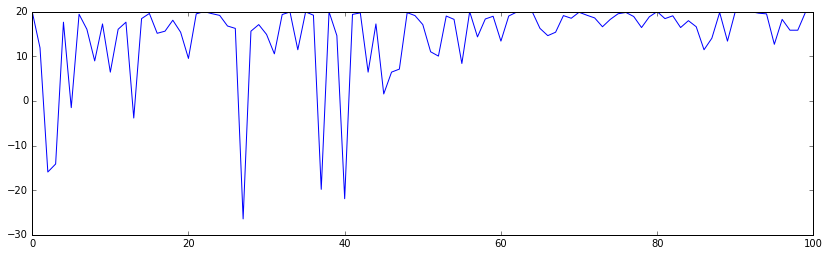

In [483]:
Action, Obs, Reward, Done = 0, 1, 2, 3
Rs = []
for traj in trajectories:
    x_0 = traj[0][Obs]
    R = 0
    for x in traj[::-1]:
        R = x[Reward] + R * gamma
    Rs.append(R)

plt.plot(range(len(Rs)), Rs)